In [1]:
import numpy as np
import cv2
from skimage import io
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
%matplotlib inline

gti_mcars=[]
gti_lcars=[]
gti_rcars=[]
gti_fcars=[]
gti_nots=[]


def initialize_xcar_etc_data():
    global gti_mcars
    global gti_lcars
    global gti_rcars
    global gti_fcars
    global gti_nots
    
#    gti_nots=[]
#    gti_lcars=[]
#    gti_rcars=[]
# Read in our vehicles and non-vehicles
    if(len(gti_nots)==0):
        gti_nots = glob.glob('./non-vehicles/non-vehicles/GTI/*png')
        dat= glob.glob('./non-vehicles/non-vehicles/Extras/*png')
        print('len',len(gti_nots),len(dat))
        gti_nots .extend(dat)
        
    if(len(gti_mcars)==0):
        gti_mcars = glob.glob('./vehicles/vehicles/GTI_MiddleClose/*.png')
    
    if(len(gti_lcars)==0):
        gti_lcars = glob.glob('./vehicles/vehicles/GTI_Left/*.png')
        
        #dat= glob.glob('./vehicles/vehicles/GTI_LeftFromR/rev/*.png')
        #print('len',len(gti_lcars),len(dat))
        #gti_lcars .extend(dat)
        
        #dat2= glob.glob('./vehicles/vehicles/GTI_LeftFromR/rev+/*.png')
        #gti_lcars .extend(dat2)
    
    if(len(gti_rcars)==0):
        gti_rcars = glob.glob('./vehicles/vehicles/GTI_Right/*.png')
        
        #dat= glob.glob('./vehicles/vehicles/GTI_RightFromL/rev/*.png')
        #print('len',len(gti_rcars),len(dat))
        #gti_rcars .extend(dat)        

        #dat2= glob.glob('./vehicles/vehicles/GTI_RightFromL/rev/*.png')
        #gti_rcars .extend(dat2)        
    
    if(len(gti_fcars)==0):
        gti_fcars = glob.glob('./vehicles/vehicles/GTI_Far/*.png')
 
    
initialize_xcar_etc_data()        
print(len(gti_mcars))       
print(len(gti_lcars))
print(len(gti_rcars))
print(len(gti_fcars))
print(len(gti_nots) )  
        
def common_color_space():
    use_cspace='YCrCb'
    return use_cspace

def common_hog_channel():
    return 'ALL'
    #return 0

import numpy as np
def zscore(x, axis = None):
####　データから平均値をとって標準偏差で割ると正規化    
    xmean = x.mean(axis=axis, keepdims=True)
    xstd  = np.std(x, axis=axis, keepdims=True)
    
    
    if(xstd==0):
        return (x>0)* (xmean/255)
    
    
    zscore = (x-xmean)/xstd
    return zscore

def min_max(x, axis=None):
####　データからを最大最小差で処理　→　階調補正 ：0〜１
    min = x.min(axis=axis, keepdims=True)
    max = x.max(axis=axis, keepdims=True)
    
    if(max==min):
        return (x>0)* (min/255)
    
    result = (x-min)/(max-min)
    return result

def x_imread(file):
    img= mpimg.imread(file)
    #２５６階調に復元： 0〜１
    img=np.clip(img*255,0,255).astype(np.uint8)
    
    img=cv2.medianBlur(img,3)
    return img



len 3900 5068
419
909
664
834
8968


In [2]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    
    conv=img.copy()
    average_square = (15, 15)
    conv=cv2.GaussianBlur(conv,average_square,1)
    
    conv=zscore(conv)
    conv=min_max(conv)    
    
    #HOGなので２５６階調に復元しなくて良い
    conv=np.clip(conv*255,0,255).astype(np.uint8)
        
    
    if vis == True:
        features, hog_image = hog(conv, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec, block_norm="L1")
        
        #fig = plt.figure()
        #plt.subplot(121)
        #plt.imshow(image, cmap='gray')
        #plt.title('Example Car Image')
        #plt.subplot(122)
        #plt.imshow(hog_image, cmap='gray')
        #plt.title('HOG Visualization')
        
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(conv, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec, block_norm="L1")
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features34(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image =x_imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
            
        
        if(hog_channel!=common_hog_channel()):
            print('********WRONG hog_channel SELECTED(extract_features34)**********',hog_channel,common_hog_channel())
        if(color_space!=common_color_space()):
            print('********WRONG color_space SELECTED(extract_features34)**********',color_space,common_color_space())
   

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

                  

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from skimage.feature import hog

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

d:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:

def disp_hog_features34(file, color_space='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    
    # Iterate through the list of images
    

    # Read in each one by one
    image =x_imread(file)
    
    hog_inp_image=np.copy(image)*0
    hog_out_image=[]
    
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      
    hog_inp_image=np.copy(feature_image)    

    if(hog_channel!=common_hog_channel()):
        print('********WRONG hog_channel SELECTED(extract_features34)**********',hog_channel,common_hog_channel())
    if(color_space!=common_color_space()):
        print('********WRONG color_space SELECTED(extract_features34)**********',color_space,common_color_space())


# Call get_hog_features() with vis=False, feature_vec=True
    hog_features = []
    if hog_channel == 'ALL':

        for channel in range(feature_image.shape[2]):
            features,image=get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=True, feature_vec=True)
            hog_features.append(features) 
            hog_out_image.append(image) 
    else:
        features,image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
        hog_features.append(features) 
        hog_out_image.append(image) 
    # Append the new feature vector to the features list

    # Return list of feature vectors
    return hog_features,hog_inp_image, hog_out_image
print('fin')

fin


In [5]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from skimage.feature import hog

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
#sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

#gti_mcars gti_lcars gti_rcars gti_fcars gti_nots
#SVC_FILE="./svc_pickle_ML.p"
#SVC_FILE="./svc_pickle_MR.p"

SVC_FILE="./svc_pickle_CMP.p"

notcars=gti_nots.copy()
cars=gti_mcars.copy()
cars.extend(gti_fcars)

if SVC_FILE=="./svc_pickle_CMP.p":
    cars.extend(gti_lcars)
    cars.extend(gti_rcars)
else:
    if SVC_FILE=="./svc_pickle_ML.p":
        cars.extend(gti_lcars)
    if SVC_FILE=="./svc_pickle_MR.p":
        cars.extend(gti_rcars)
        
        
print(len(cars),len(notcars))

print(len(gti_mcars))       
print(len(gti_lcars))
print(len(gti_rcars))
print(len(gti_fcars))
print(len(gti_nots) )  
        


2826 8968
419
909
664
834
8968


In [38]:
import pickle
#SVC_FILE='./svc_pickle_ML.p'
print(SVC_FILE)


LFeat='./lFeautures.p'
RFeat='./rFeautures.p'
CFeat='./cFeautures.p'

TxFeat=CFeat

if(SVC_FILE=='./svc_pickle_ML.p'):
    TxFeat=LFeat

if(SVC_FILE=='./svc_pickle_MR.p'):
    TxFeat=RFeat
    

features_pickle = pickle.load( open(TxFeat, "rb" ) )

car_features=features_pickle["car_features"]
notcar_features=features_pickle["notcar_features"]

orient=features_pickle["orient"] 
pix_per_cell=features_pickle["pix_per_cell"] 
cell_per_block=features_pickle["cell_per_block"] 
spatial_size=features_pickle["spatial_size"] 
hist_bins=features_pickle["hist_bins"] 
hog_channel=features_pickle["hog_channel"] 

color_space=features_pickle["color_space"] 
spatial_feat=features_pickle["spatial_feat"]  
hist_feat =features_pickle["hist_feat"] 
hog_feat=features_pickle["hog_feat"] 
############################################################


dist_pickle = pickle.load( open(SVC_FILE, "rb" ) )
print('loaded' ,SVC_FILE)
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]


X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
#X_scaler = StandardScaler().fit(X)
X_scaler= MinMaxScaler().fit(X)
#X_scaler=MaxAbsScaler.fit(X)
#X_scaler= RobustScaler().fit(X)



# Apply the scaler to X


# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaler.transform(X) , y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

print(svc)
print(X_scaler)

print('spatial_size' ,spatial_size ,'hist_bins' ,hist_bins )

print('task finished')



./svc_pickle_CMP.p
loaded ./svc_pickle_CMP.p
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
Test Accuracy of SVC =  0.9992
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
MinMaxScaler(copy=True, feature_range=(0, 1))
spatial_size (32, 32) hist_bins 32
task finished


In [47]:
report_car_features =[]
report_notcar_features =[]
reset_data =False

if(reset_data==True):
    report_car_features.append(car_features)
    report_notcar_features.append(notcar_features)
    
    for loop in range(3):
        f=   extract_features34(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=(loop==0), 
                            hist_feat=(loop==1) , hog_feat=(loop==2) )
        report_car_features.append(f)
        f=   extract_features34(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=(loop==0), 
                            hist_feat=(loop==1) , hog_feat=(loop==2) )
        report_notcar_features.append(f)


    import pickle
    report_features_pickle={}
    report_features_pickle["report_car_features"] = report_car_features
    report_features_pickle["report_notcar_features"] = report_notcar_features
    pickle.dump( report_features_pickle, open('./report_features.p' , "wb" ) )

print('fin')

fin


In [48]:
import pickle

report_features_pickle = pickle.load( open('./report_features.p', "rb" ) )

report_car_features=   report_features_pickle["report_car_features"] 
report_notcar_features=report_features_pickle["report_notcar_features"] 


print(len(report_car_features))
print(len(report_notcar_features))
print('report_features loaded')

4
4
report_features loaded


1971 7194


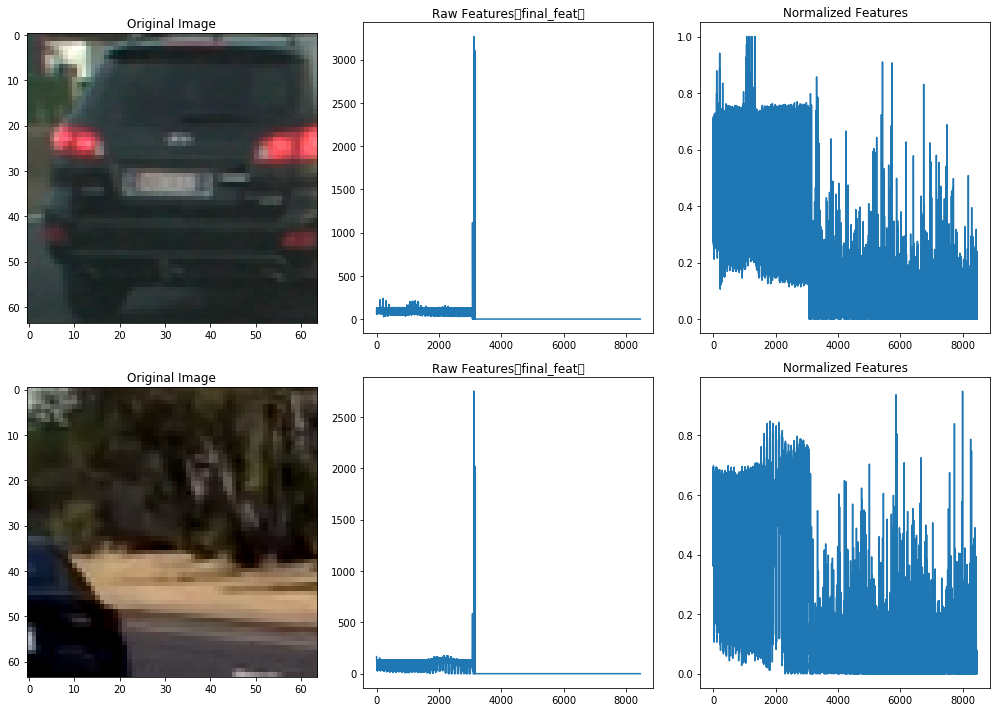

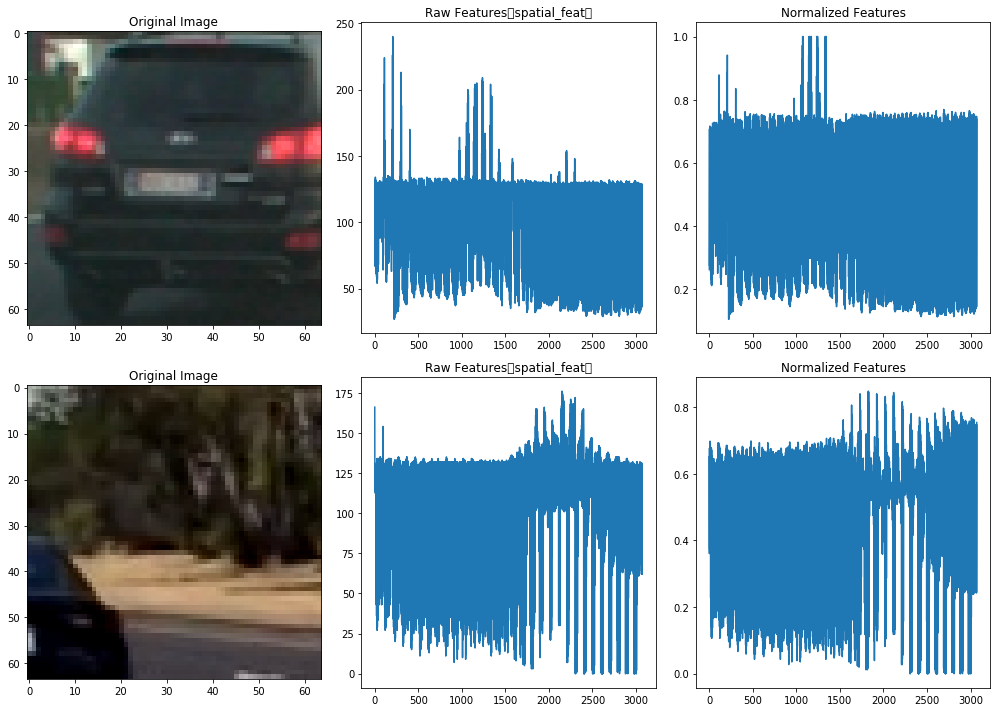

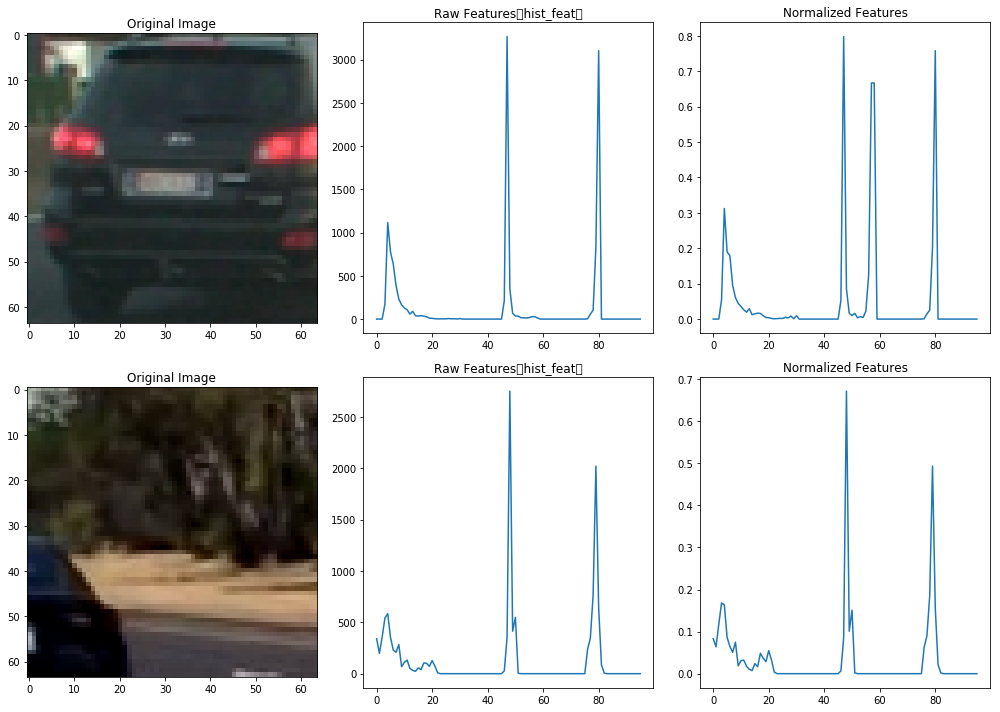

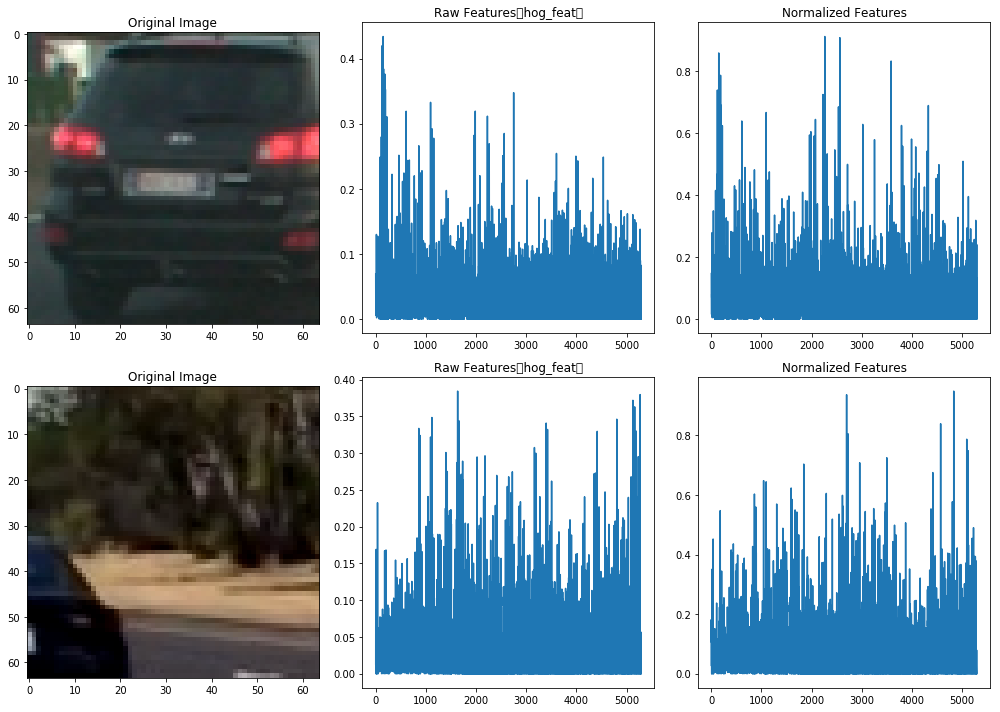

d:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(64, 64, 3)
(64, 64, 3)


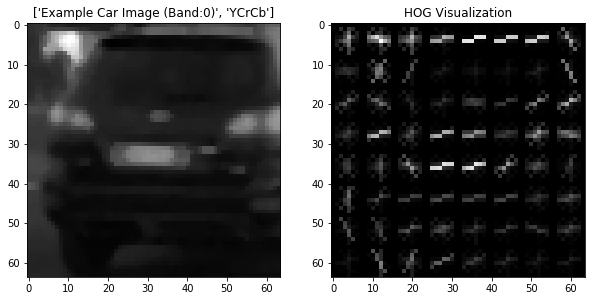

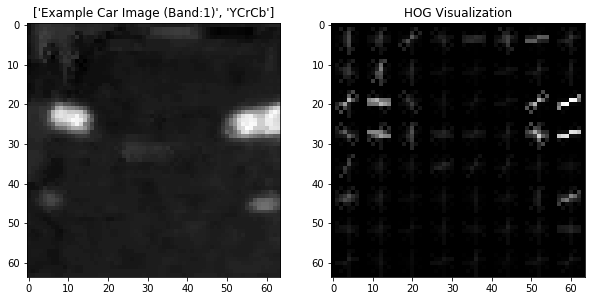

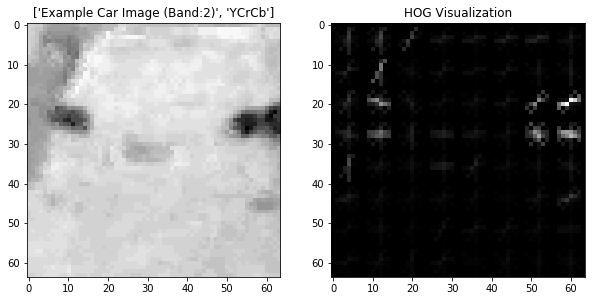

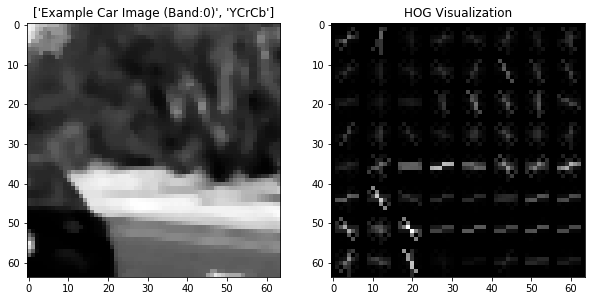

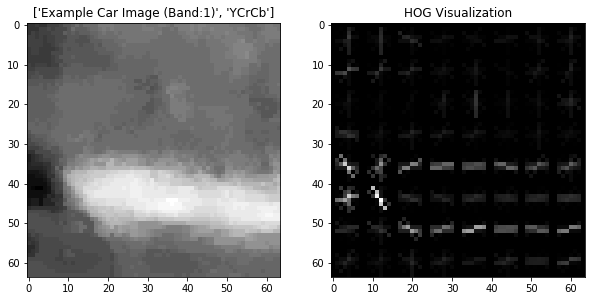

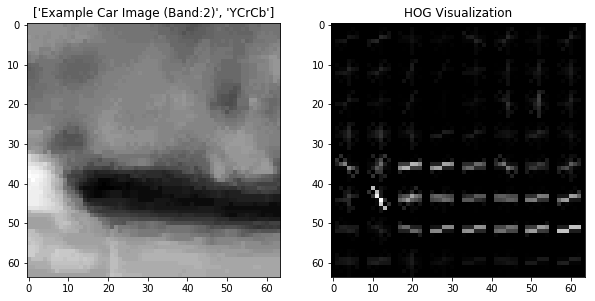

In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

#car_ind = np.random.randint(0, len(cars))    
#notcar_ind = np.random.randint(0, len(notcars))    
car_ind = 1971
notcar_ind = 7194

#car_ind = car_ind//2
#notcar_ind = notcar_ind//2



print(car_ind,notcar_ind)


for loop in range(4):
    lenfeautures=[len(report_car_features[loop]),len(report_notcar_features[loop])]
    
    rep_X = np.vstack((report_car_features[loop], report_notcar_features[loop])).astype(np.float64)     
    rep_X_scaler = MinMaxScaler().fit(rep_X)
    rep_scaled_X = rep_X_scaler.transform(rep_X)
    # Plot an example of raw and scaled features
    
    fig = plt.figure(figsize=(14,10))
    
    if loop==0:
        xtitle='Raw Features（final_feat）'
    if loop==1:
        xtitle='Raw Features（spatial_feat）'
    if loop==2:        
        xtitle='Raw Features（hist_feat）'
    if loop==3:
        xtitle='Raw Features（hog_feat）'
        
    plt.subplot(231)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(232)
    plt.plot(rep_X[car_ind])
    plt.title(xtitle)
    plt.subplot(233)
    plt.plot(rep_scaled_X[car_ind])
    plt.title('Normalized Features')
       
    
    plt.subplot(234)
    plt.imshow(mpimg.imread(notcars[notcar_ind]))
    plt.title('Original Image')
    plt.subplot(235)
    plt.plot(rep_X[notcar_ind+ lenfeautures[0] ])
    
    plt.title(xtitle)
    plt.subplot(236)
    plt.plot(rep_scaled_X[notcar_ind+ lenfeautures[0] ])
    plt.title('Normalized Features')
    fig.tight_layout()
    plt.show()
    
    
    
##########################################################


hog_features,hog_inp_image, hog_out_image= disp_hog_features34(
                    cars[car_ind], color_space=color_space, 
                    orient=orient, pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block,hog_channel=hog_channel)
print(hog_inp_image.shape)

# Plot the examples
for i in range(len(hog_out_image)):
    fig = plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(hog_inp_image[:,:,i], cmap='gray')
    xtitle='Example Car Image (Band:%d)'% i
    plt.title([xtitle,color_space])
    plt.subplot(122)
    plt.imshow(hog_out_image[i], cmap='gray')
    plt.title('HOG Visualization')


hog_features,hog_inp_image, hog_out_image= disp_hog_features34(
                    notcars[notcar_ind], color_space=color_space, 
                    orient=orient, pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block,hog_channel=hog_channel)
print(hog_inp_image.shape)

# Plot the examples
for i in range(len(hog_out_image)):
    fig = plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(hog_inp_image[:,:,i], cmap='gray')
    xtitle='Example Car Image (Band:%d)'% i
    plt.title([xtitle,color_space])
    plt.subplot(122)
    plt.imshow(hog_out_image[i], cmap='gray')
    plt.title('HOG Visualization')    


In [50]:

def my_slide_window3(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                     min_window=64, xy_step=(0.5,0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    ##print('xy_step',xy_step)
    window_list = []

    
    x0=x_start_stop[0]
    xw=x_start_stop[1]
    
    
    y0=y_start_stop[0]
    yh=y_start_stop[1]
    #開始位置
    w0=min_window
    #終了位置
    wh=(yh-y0)*2//3

    y=y_start_stop[0]
    
    cx=img.shape[1]//2
    
    while(y<y_start_stop[1]):
        w=((wh-w0)/(yh-y0))*(y-y0)+w0
        xadd=max(2,np.int(w*xy_step[0]))
        x=x_start_stop[0]
        while(x<x_start_stop[1]):
            
            wx=((wh-w)/cx*np.absolute(x-cx)+w )
            wy=min(w*1.1,(w+wx)/2)
            l=x
            t=y
            r=l+np.int(wx)
            b=t+np.int(wy)
            if(r>=x_start_stop[1]):
                break
            if(b>=y_start_stop[1]):
                break
                 
            window_list.append(((l,t), (r,b))) 
            x=x+xadd
                 
        yadd=max(2,np.int(w*xy_step[1]))
        y=y+yadd
   
   
    return  window_list              
                 

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
print("test")


test


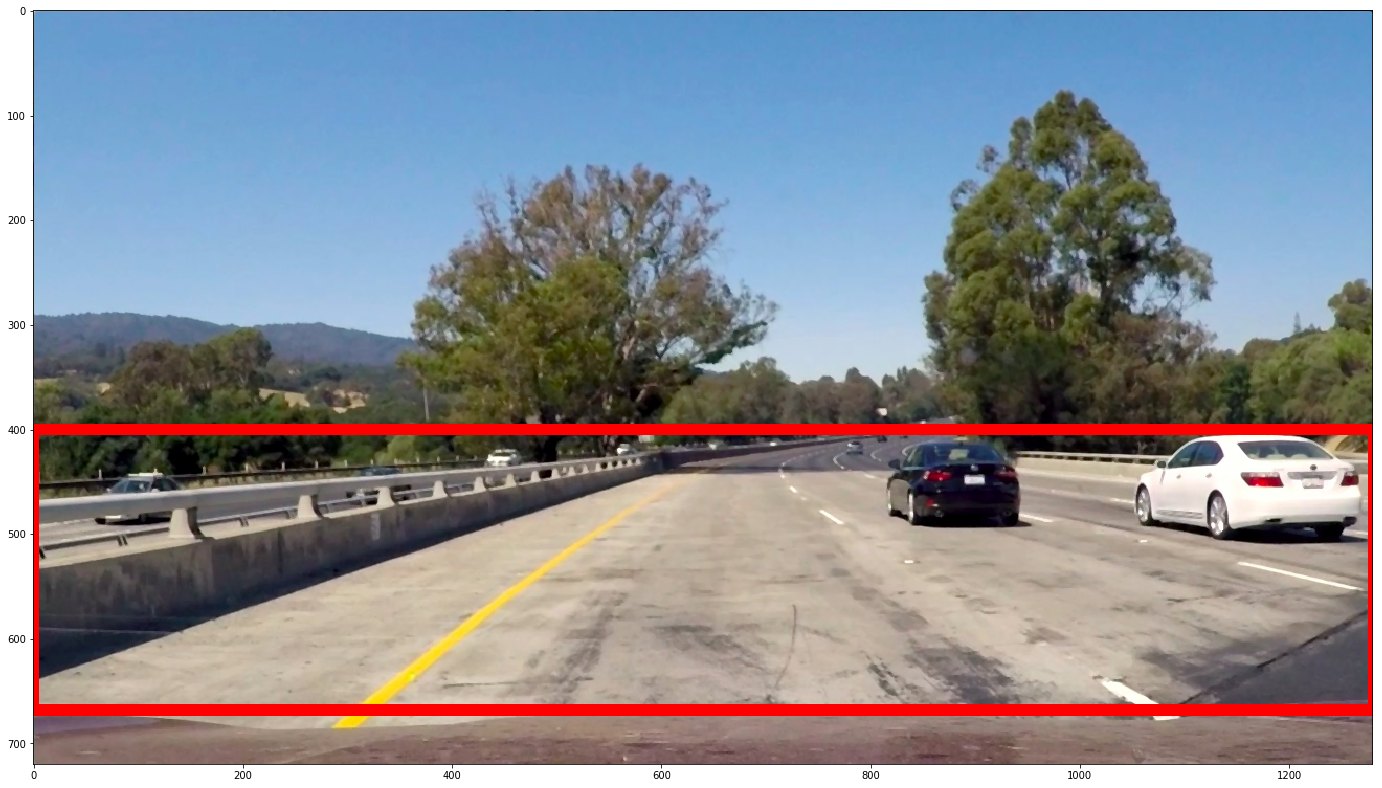

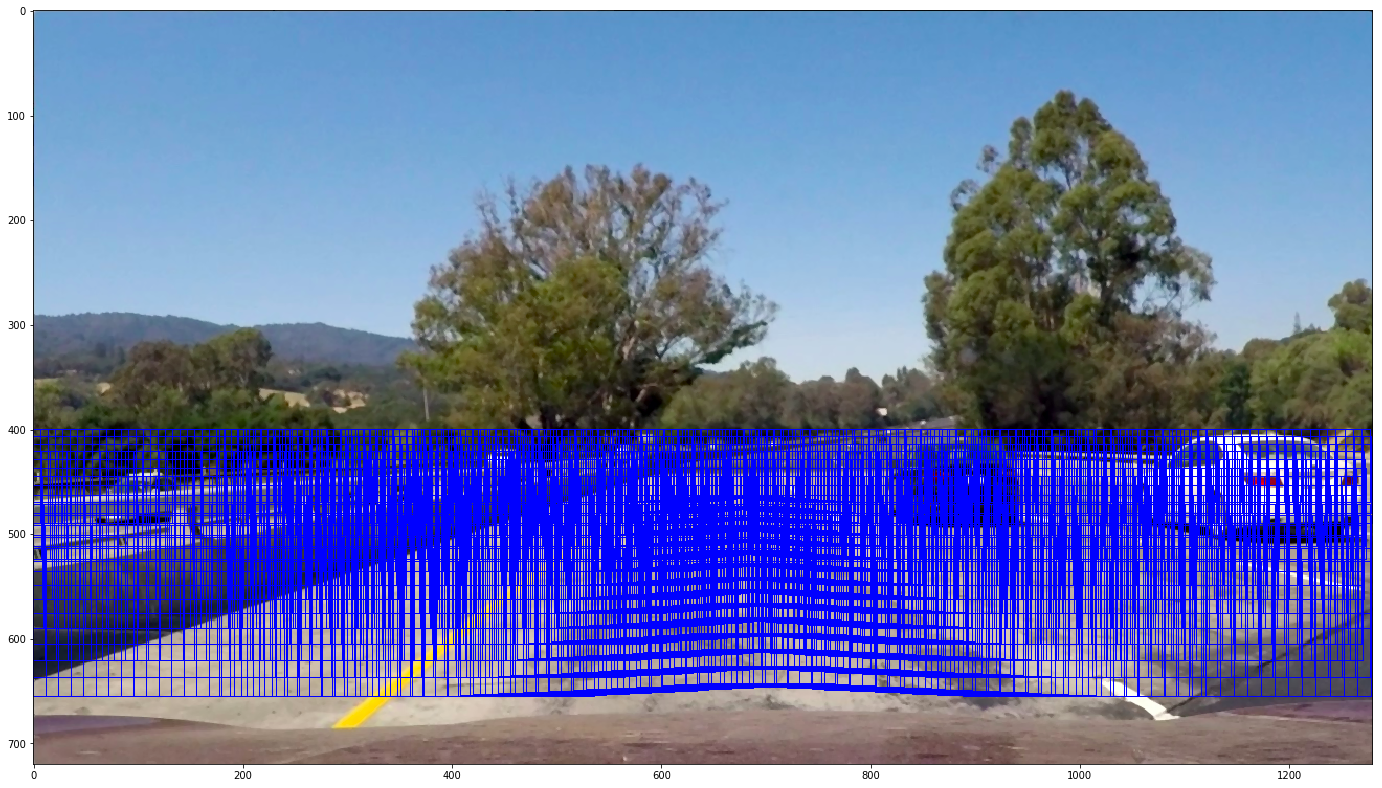

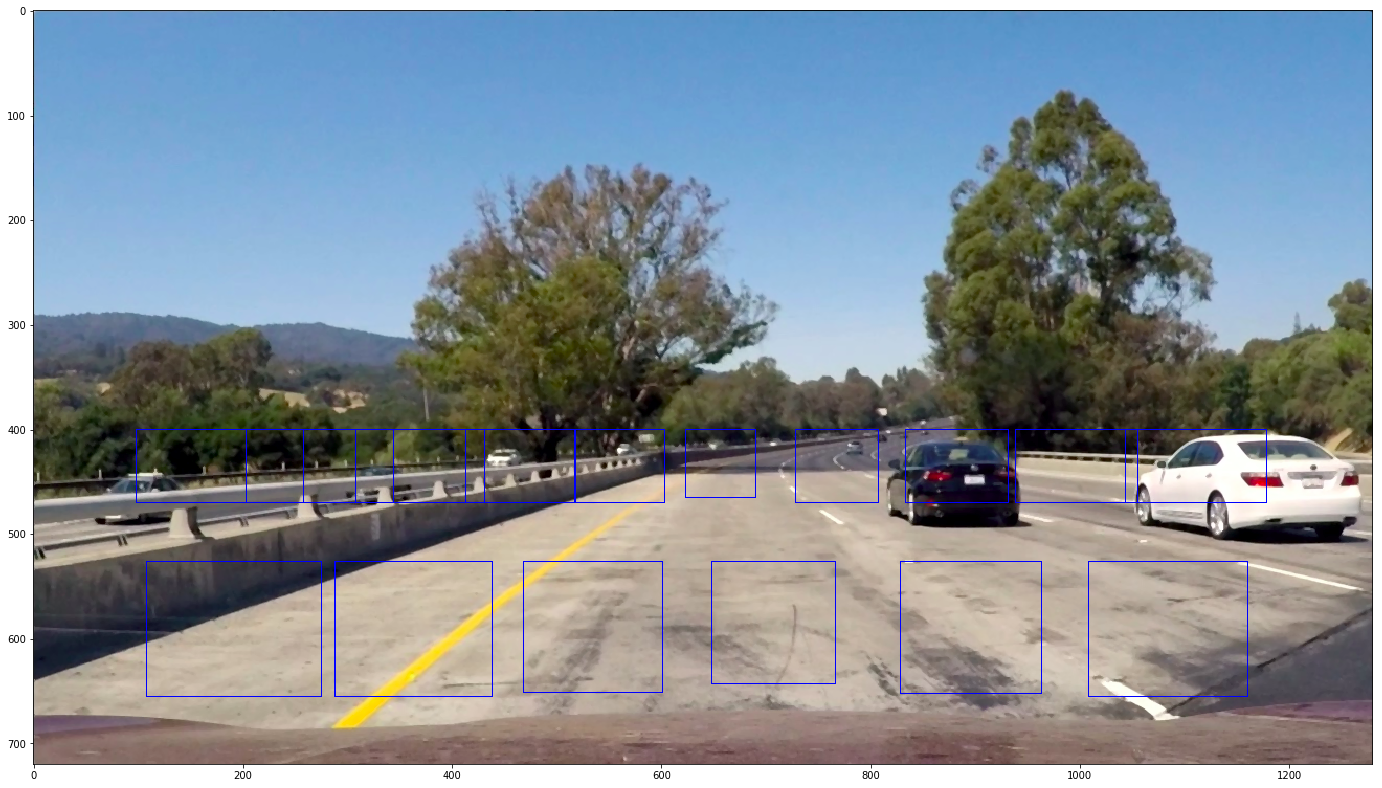

In [30]:

file='./test_images/test1.png'
image= x_imread(file)

x_start_stop=[0,image.shape[1]]
y_start_stop=[400,668]


windows = my_slide_window3(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop,min_window=64, xy_step=(0.11,0.11))


plt.figure(figsize=(24,16))
mask=cv2.rectangle(image.copy(),(x_start_stop[0],y_start_stop[0])
                               ,(x_start_stop[1],y_start_stop[1]),(255,0,0), 10)

plt.imshow(mask)
plt.show()


draw=draw_boxes(image,windows,(0,0,255),1)
plt.figure(figsize=(24,16))
plt.imshow(draw)
plt.show()


pickup=[]
skip=0
tmax=0
for box in windows:
    skip=skip+1
    if(skip%15):
        continue 
    l=box[0][0]
    t=box[0][1]
    r=box[1][0]
    b=box[1][1]
    
    tmax=max(t,tmax)
    if(t!=400):
        continue
    pickup.append(box)

for box in windows:
    skip=skip+1
    if(skip%15):
        continue 
    l=box[0][0]
    t=box[0][1]
    r=box[1][0]
    b=box[1][1]
    
    if(t!=tmax):
        continue
    pickup.append(box)    
    
draw=draw_boxes(image,pickup,(0,0,255),1)
plt.figure(figsize=(24,16))
plt.imshow(draw)
plt.show()


In [61]:
print(len(windows))

1902
